In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [60]:
# read dataset
with open('../data/Zip_Zhvi_SingleFamilyResidence.csv', 'rb') as f:
    df = pd.read_csv(f).fillna(0)

# convert non-timeseries
df[['City', 'State', 'Metro', 'CountyName']] = df[['City', 'State', 'Metro', 'CountyName']].astype(str)
df[['RegionID', 'RegionName', 'SizeRank']] = df[['RegionID', 'RegionName', 'SizeRank']].astype(int)

# convert to lowercase
df[['City', 'State', 'Metro', 'CountyName']] = df[['City', 'State', 'Metro', 'CountyName']].apply(
  lambda x: x.astype(str).str.lower()
)

# timeseries data
start_index = df.columns.get_loc('1996-04') + 1
date_columns = df.iloc[:,start_index:len(df.columns)].columns.tolist()

# ensure integer timeseries
df[date_columns] = df[date_columns].astype(int)

In [92]:
# metro areas
hot_springs = df.loc[(df['Metro'] == 'hot springs') & (df['State'] == 'ar')]
little_rock = df.loc[(df['Metro'] == 'little rock') & (df['State'] == 'ar')]
fayetteville = df.loc[(df['Metro'] == 'fayetteville') & (df['State'] == 'ar')]
searcy = df.loc[(df['Metro'] == 'searcy') & (df['State'] == 'ar')]

In [93]:
print(hot_springs)

       RegionID  RegionName         City State        Metro CountyName  \
250       89249       71913  hot springs    ar  hot springs    garland   
2533      89244       71901  hot springs    ar  hot springs    garland   
10833     89281       71968        royal    ar  hot springs    garland   
11879     89278       71964       pearcy    ar  hot springs    garland   

       SizeRank  1996-04  1996-05  1996-06   ...     2016-12  2017-01  \
250         251  75400.0    76000    76300   ...      143700   144000   
2533       2534  68000.0    68700    69100   ...      116500   117000   
10833     10834  81600.0    81100    80000   ...      154600   155800   
11879     11880  75700.0    75700    75200   ...      142200   143400   

       2017-02  2017-03  2017-04  2017-05  2017-06  2017-07  2017-08  2017-09  
250     143900   144000   144600   145600   146400   146800   147800   149000  
2533    117800   119100   120800   122100   122800   123000   123000   123200  
10833   156800   157500

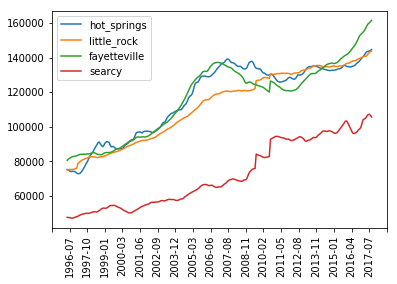

In [142]:
# timeseries plot
fig, ax = plt.subplots()
ax.plot(hot_springs[date_columns].mean(), linestyle='solid')
ax.plot(little_rock[date_columns].mean(), linestyle='solid')
ax.plot(fayetteville[date_columns].mean(), linestyle='solid')
ax.plot(searcy[date_columns].mean(), linestyle='solid')

# decrease ticks
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax, 20), 2))

# rotate ticks + show legend
plt.xticks(rotation=90)
plt.gca().legend(('hot_springs', 'little_rock', 'fayetteville', 'searcy'))

# show overall plot
plt.show()